In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
import numpy as np
from matplotlib.offsetbox import AnchoredText
import statsmodels.formula.api as smf

# Import and organize data

In [53]:
males = pd.read_csv('/Users/minneschepers/Desktop/HCP/Data/Males_exp.csv')
females = pd.read_csv('/Users/minneschepers/Desktop/HCP/Data/Females_exp.csv')

In [37]:
# Order tda columns in lists
tda_features = males.columns[27:]

DMN_curvatures = [i for i in tda_features if 'DMN' in i if 'curv' in i]
FPN_curvatures = [i for i in tda_features if 'FPN' in i if 'curv' in i]
all_curvatures = [i for i in tda_features if 'all' in i if 'curv' in i]
p3_cliques = [i for i in tda_features if 'p3cliques' in i]
p4_cliques = [i for i in tda_features if 'p4cliques' in i]
global_features = [i for i in tda_features if i not in DMN_curvatures if i not in FPN_curvatures if i not in all_curvatures if i not in p3_cliques if i not in p4_cliques]

WM_age = ['lswmt_age']
EF_age = ['dccs_age', 'flanker_age', 'EF_age']
all_kur = [i for i in tda_features if 'kur' in i]
all_skew = [i for i in tda_features if 'skew' in i]
all_std = [i for i in tda_features if 'std' in i]
all_ent = [i for i in tda_features if 'curv_ent' in i]

In [19]:
WM = ['lswmt_unadjusted', 'lswmt_age']
EF = ['dccs_unadjusted', 'dccs_age',
       'flanker_unadjusted', 'flanker_age',
      'EF_unadjusted', 'EF_age']

# Define functions for data exploration

In [60]:
def regplot_mf(X_column, y_column, order):
    
    order = order

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    fig.suptitle(X_column)

    # Plot males
    df = males
    X = df[X_column]
    y = df[y_column]
    
    model = np.poly1d(np.polyfit(X, y, order))
    results = smf.ols(formula='y ~ model(X)', data=df).fit()
    R2 = results.rsquared
    p_value = results.f_pvalue
    
    sns.regplot(x=X, y=y, ax=ax1)
    anchored_text = AnchoredText(f' R2: {R2:.5f} \n p: {p_value:.5f}', loc=1)
    ax1.add_artist(anchored_text)
    ax1.title.set_text('Males')
    
    # Plot females
    df = females
    X = df[X_column]
    y = df[y_column]
    
    model = np.poly1d(np.polyfit(X, y, order))
    results = smf.ols(formula='y ~ model(X)', data=df).fit()
    R2 = results.rsquared
    p_value = results.f_pvalue

    sns.regplot(x=X, y=y, order=order, ax=ax2)
    anchored_text = AnchoredText(f' R2: {R2:.5f} \n p: {p_value:.5f}', loc=1)
    ax2.add_artist(anchored_text)
    ax2.title.set_text('Females')

    plt.show()

In [11]:
def regplot(X_column, y_column, df, order):
    
    order = order
    
    X = df[X_column]
    y = df[y_column]
    
    model = np.poly1d(np.polyfit(X, y, order))
    results = smf.ols(formula='y ~ model(X)', data=df).fit()
    R2 = results.rsquared
    p_value = results.f_pvalue

    sns.regplot(x=X, y=y, order=order)
    plt.figtext(0.72, 0.78, f' R2: {R2} \n p: {p_value}', fontsize=10)
    plt.xlabel(X_column)
    plt.ylabel(y_column)
    plt.show()

In [12]:
def z_scored_df(df, X_column, cut_off, print_zscores):
    
    z_scored = np.abs(stats.zscore(df[X_column]))
    if print_zscores == 1:
        print(z_scored)
    filtered = (z_scored < cut_off)
    df_new = df[filtered]
    
    print(f'Number excluded: {df.shape[0] - df_new.shape[0]}')
    
    return df_new

In [13]:
def z_scored_regplot(x, y, dataframe, cut_off, print_zscores, order):
    
    X_column = x
    y = y
    df = dataframe
    
    regplot(X_column, y, z_scored_df(df, X_column, cut_off=cut_off, print_zscores=print_zscores), order)

In [14]:
def regplots(X_column, y_column, df, zscore):
    
    order = 2
    
    if zscore == 0:
        df = df
    else:
        df = z_scored_df(df, X_column, cut_off=zscore, print_zscores=0)
    
    X = df[X_column]
    y = df[y_column]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    fig.suptitle(X_column)

    # Plot linear regression
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p_value = est2.pvalues[1]
    R2 = est2.rsquared
    
    sns.regplot(x=X, y=y, ax=ax1)
    anchored_text = AnchoredText(f' R2: {R2:.5f} \n p: {p_value:.5f}', loc=1)
    ax1.add_artist(anchored_text)
    
    # Plot polynomial regression
    model = np.poly1d(np.polyfit(X, y, order))
    results = smf.ols(formula='y ~ model(X)', data=df).fit()
    R2 = results.rsquared
    p_value = results.f_pvalue

    sns.regplot(x=X, y=y, order=order, ax=ax2)
    anchored_text = AnchoredText(f' R2: {R2:.5f} \n p: {p_value:.5f}', loc=1)
    ax2.add_artist(anchored_text)
    
    plt.show()

In [55]:
def get_best_predictors(x, y, dataframe, n, zscore):
        
    # This function gets the n best predictors for a target and produces regression plots
    
    print(f'\n---------------- y = {y} ----------------\n')
    df = dataframe
    columns = []
    
    [columns.append(i) for i in x]
    columns.append(y)

    # Create correlation matrix
    corr = df[columns].corr()
    # Only include column with corr values with y-column, and exclude row with y (autocorrelation)
    # Absolutize to also get large negative correlation values
    corr = np.abs(corr.iloc[:-1,-1:])
    # Get n largest corr values
    corr = corr.nlargest(n, corr.columns)
    print(corr)
    print('\n')
    # Save predictors to list
    best_predictors = corr.index.to_list()
    # Make for each predictor regression plot
    [regplots(predictor, y, df, zscore) for predictor in best_predictors]
    
    return best_predictors
    
# get_best_predictors(global_features, 'fluidcog_age', df_no_nan, n=3, zscore=0)

# Relationship between age and TDA for males and females


---------------- y = age_years ----------------

                   age_years
bc_AUC_dim0         0.385783
S_entropy_dim0      0.362699
curv_std_FPN_0.05   0.195728
curv_std_DMN_0.05   0.192331
curv_std_all_0.05   0.184864
bc_AUC_dim1         0.176704
curv_std_all_0.02   0.174709
curv_std_FPN_0.02   0.168747
S_entropy_dim1      0.159050
top_vec_dim0        0.153746


Number excluded: 1


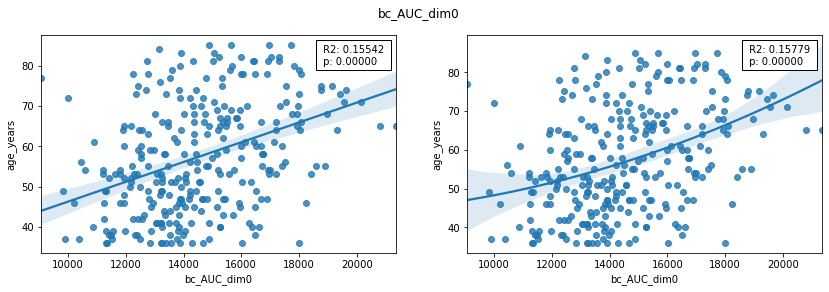

Number excluded: 4


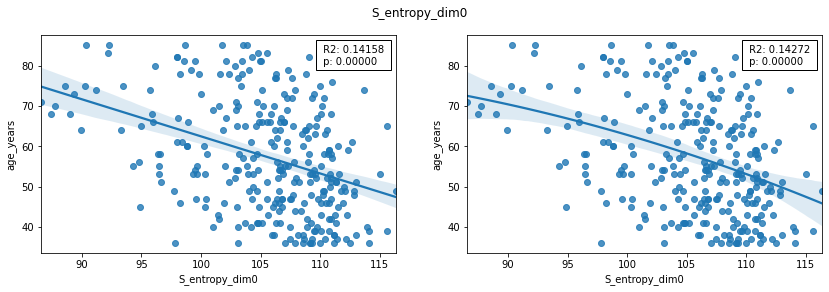

Number excluded: 6


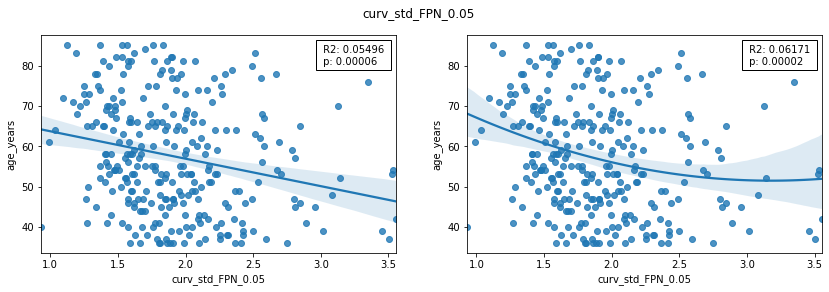

Number excluded: 5


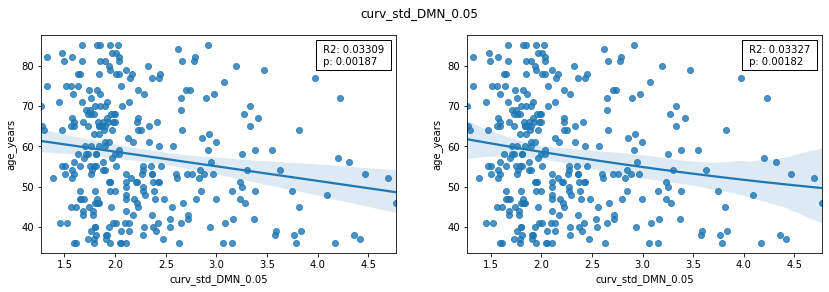

Number excluded: 5


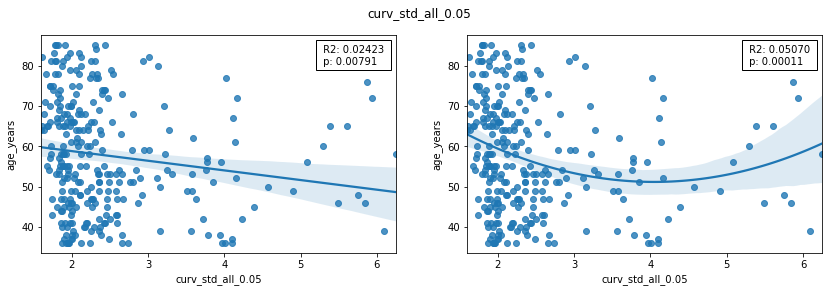

Number excluded: 0


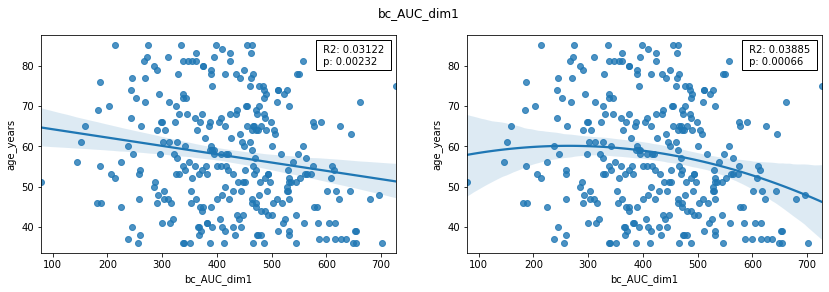

Number excluded: 2


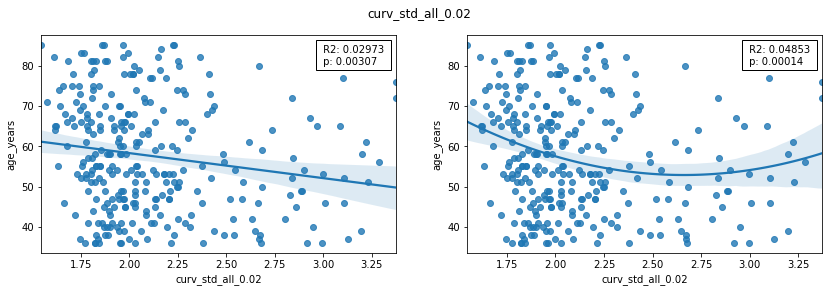

Number excluded: 5


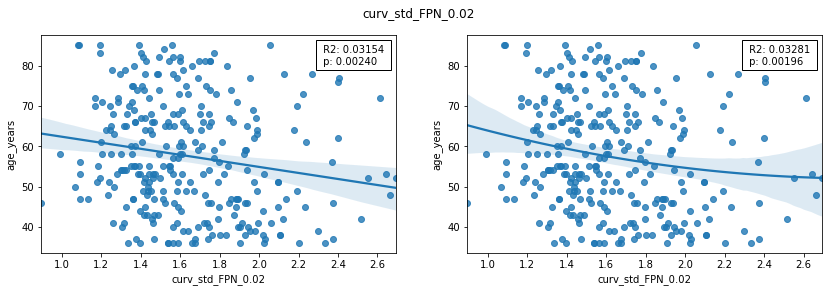

Number excluded: 2


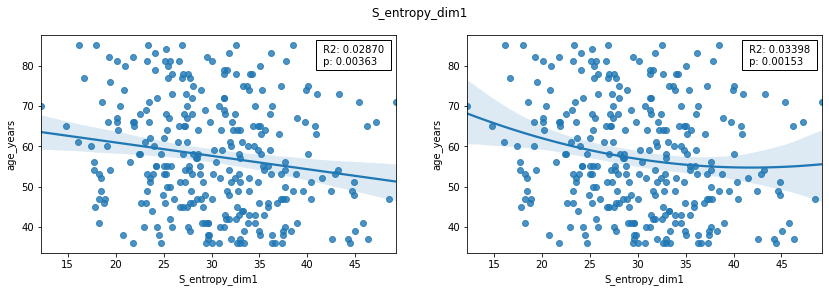

Number excluded: 3


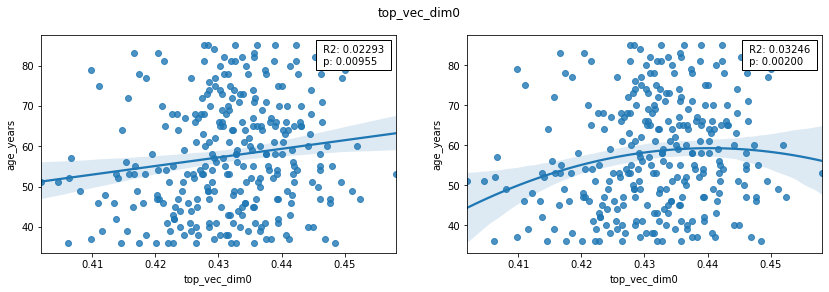

In [58]:
selected_features = list(tda_features)
to_remove = ['curv_skew_FPN_0.05', 'curv_kur_FPN_0.05']

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features]

best_predictors = get_best_predictors(selected_features, 'age_years', malesfemales, n=10, zscore=3)

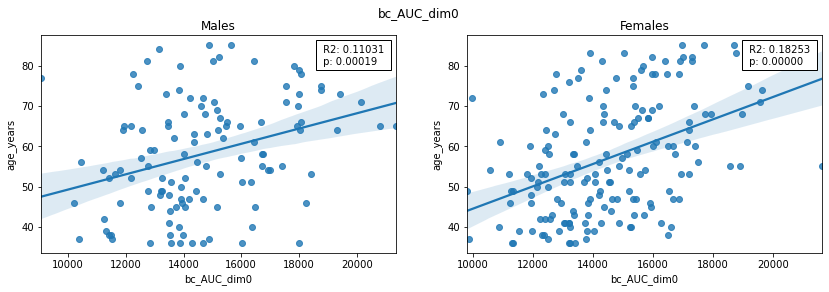

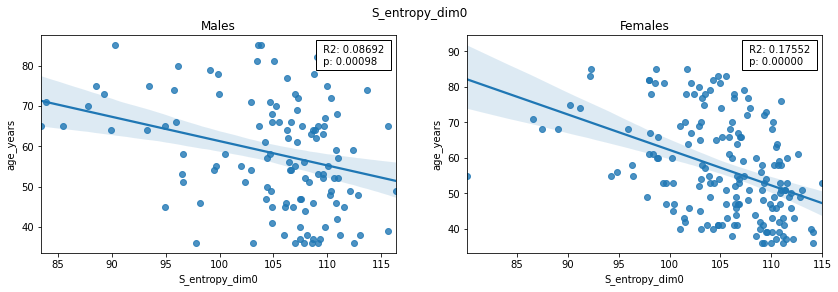

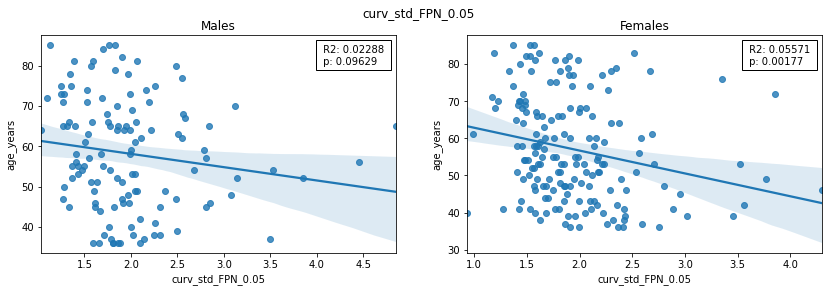

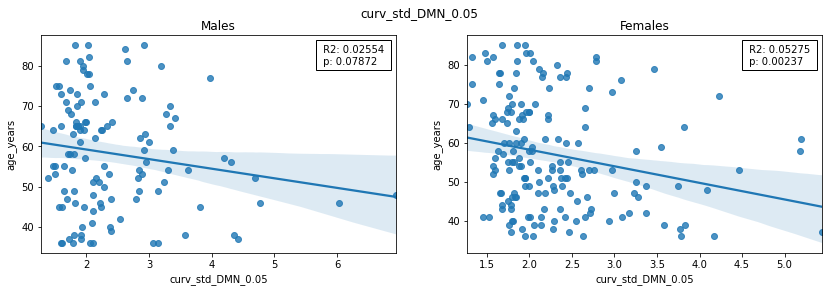

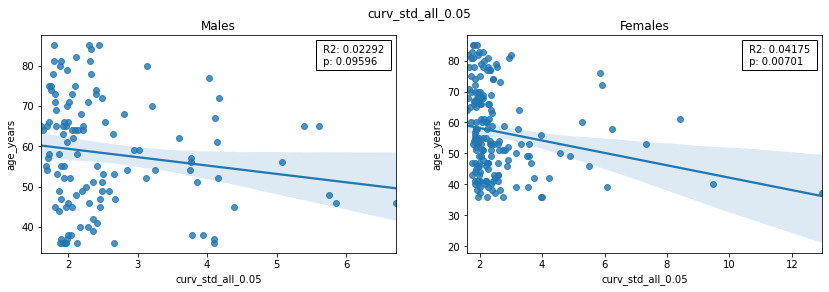

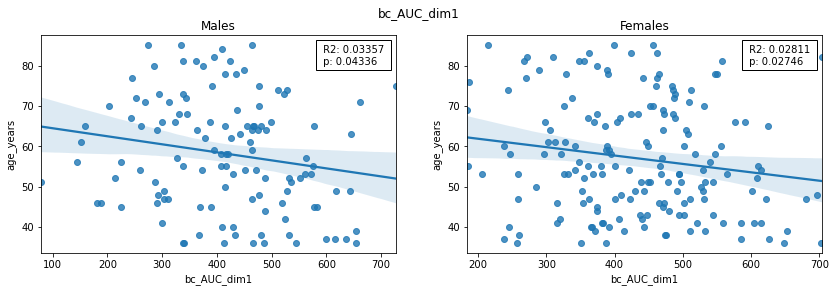

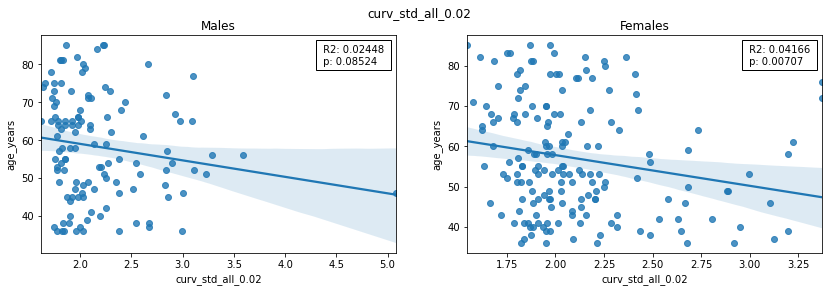

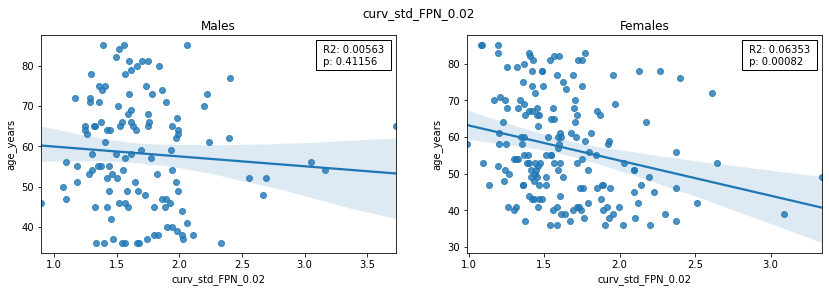

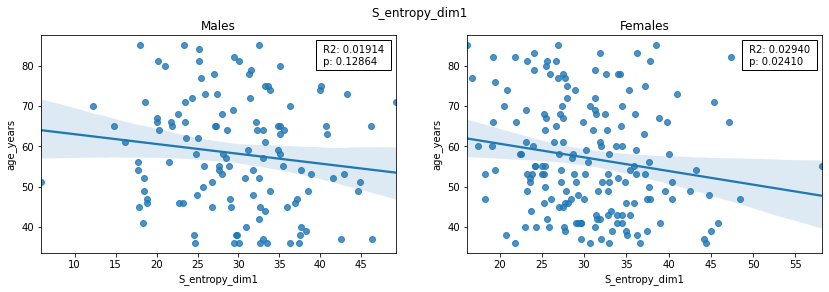

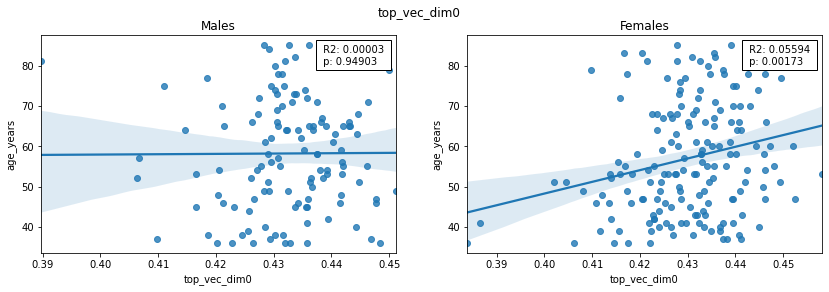

In [59]:
for x in best_predictors:
    regplot_mf(x, 'age_years', 1)


---------------- y = age_years ----------------

                   age_years
bc_AUC_dim0         0.332123
S_entropy_dim0      0.294829
bc_AUC_dim1         0.183234
curv_std_DMN_0.02   0.163044
curv_std_DMN_0.05   0.159799


Number excluded: 0


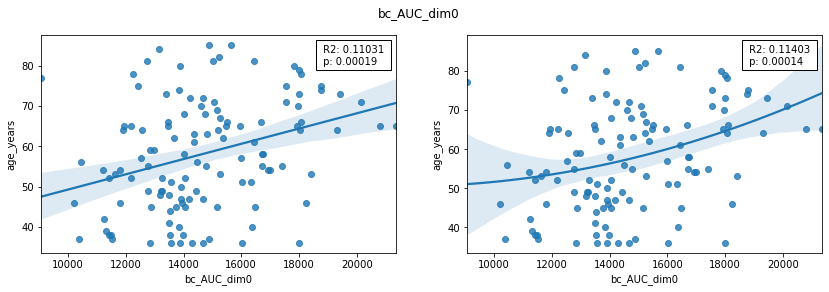

Number excluded: 2


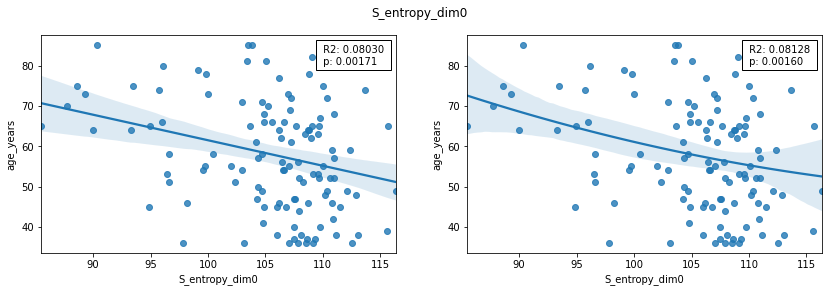

Number excluded: 0


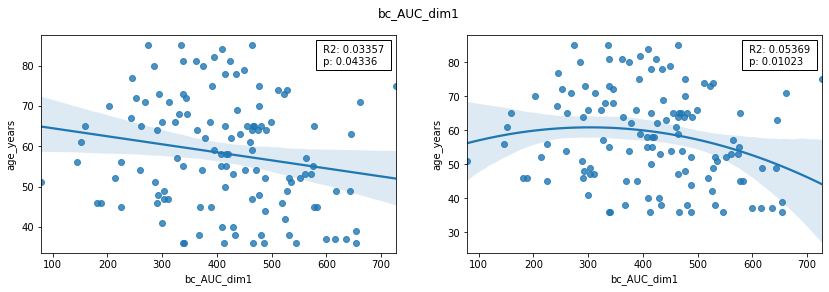

Number excluded: 2


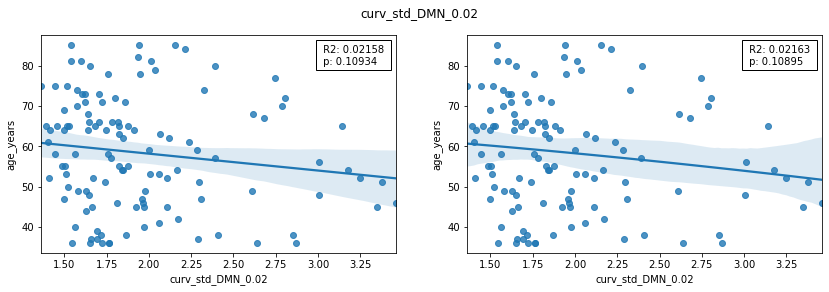

Number excluded: 2


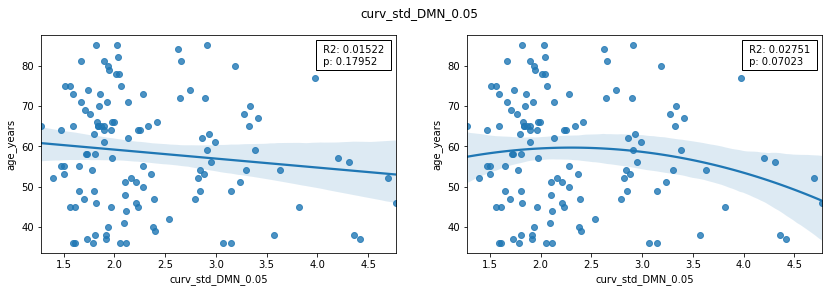

In [64]:
selected_features = list(tda_features)
to_remove = ['curv_skew_FPN_0.05', 'curv_kur_FPN_0.05']

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features]

best_predictors = get_best_predictors(selected_features, 'age_years', males, n=5, zscore=3)


---------------- y = age_years ----------------

                   age_years
bc_AUC_dim0         0.427240
S_entropy_dim0      0.418952
curv_std_FPN_0.02   0.252059
top_vec_dim0        0.236508
curv_std_FPN_0.05   0.236024


Number excluded: 1


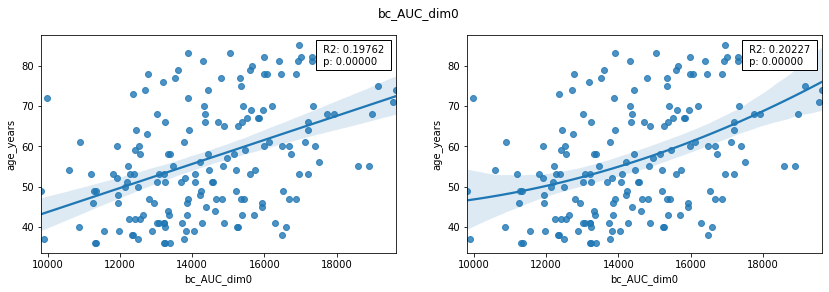

Number excluded: 3


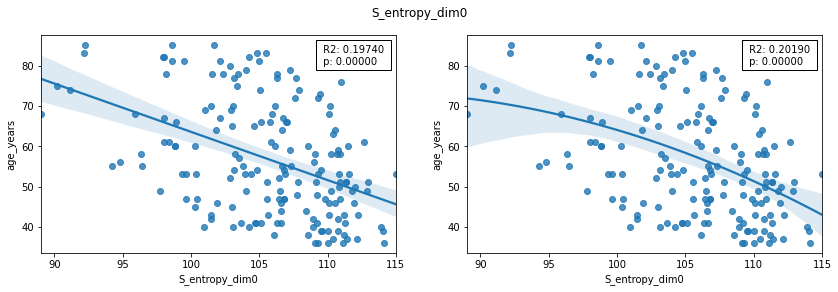

Number excluded: 2


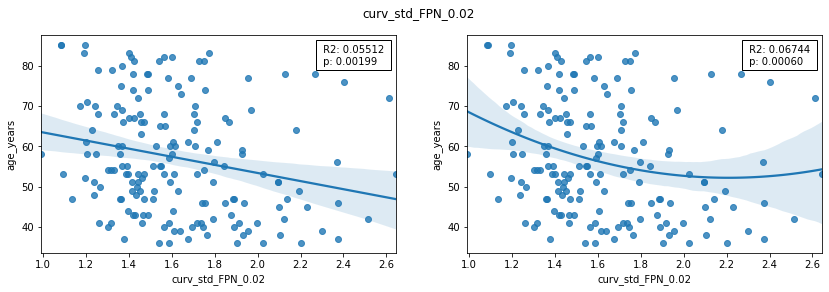

Number excluded: 2


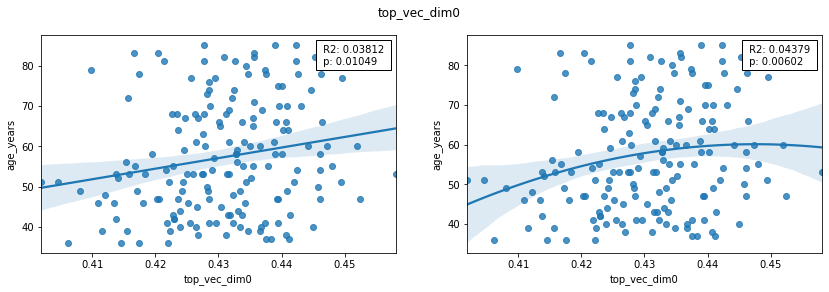

Number excluded: 4


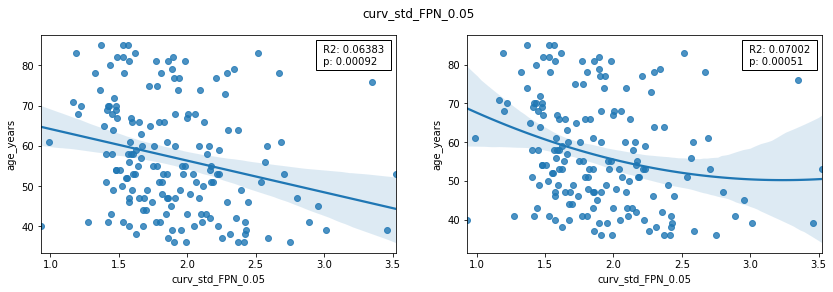

In [65]:
selected_features = list(tda_features)
to_remove = ['curv_skew_FPN_0.05', 'curv_kur_FPN_0.05']

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features]

best_predictors = get_best_predictors(selected_features, 'age_years', females, n=5, zscore=3)